## FNED and FPED Implementation

In [1]:
import pandas as pd
import numpy as np
import math

#### Read Original Data

In [2]:
data_dir = "age"
df = pd.read_csv("occ-age/prepared/" + data_dir + ".csv")
df["label"] = df["0"]
df = df.iloc[:,2:]
df

,mutant,template,original,age,name,label
0,"b "" The Mascot is Starewicz's masterpiece. It ...","b "" The Mascot is Starewicz's masterpiece. It ...","b "" The Mascot is Ladislaw Starewicz's masterp...",young,Starewicz,1
1,"b "" The Mascot is Starewicz's masterpiece. It ...","b "" The Mascot is Starewicz's masterpiece. It ...","b "" The Mascot is Ladislaw Starewicz's masterp...",old,Starewicz,1
2,"b "" I have only see three episodes of Hack, st...","b "" I have only see three episodes of Hack, st...","b "" I have only see three episodes of Hack, st...",young,David Morse,1
3,"b "" I have only see three episodes of Hack, st...","b "" I have only see three episodes of Hack, st...","b "" I have only see three episodes of Hack, st...",old,David Morse,1
4,"b ' Deepa Mehta's "" Fire "" is groundbreaking, ...","b ' Deepa Mehta's "" Fire "" is groundbreaking, ...","b ' Deepa Mehta's "" Fire "" is groundbreaking, ...",young,Shabana Azmi,1
...,...,...,...,...,...,...
36909,"b "" How do you describe perfection? In - the -...","b "" How do you describe perfection? In - the -...","b "" How do you describe perfection? In - the -...",old,Maggie Cheung,1
36910,"b "" The French Babbette appears at the modest ...","b "" The French Babbette appears at the modest ...","b "" The French Babbette appears at the modest ...",young,Babette,1
36911,"b "" The French Babbette appears at the modest ...","b "" The French Babbette appears at the modest ...","b "" The French Babbette appears at the modest ...",old,Babette,1
36912,"b "" First, I'm a huge Buddy Holly fan. I grew ...","b "" First, I'm a huge Buddy Holly fan. I grew ...","b "" First, I'm a huge Buddy Holly fan. I grew ...",young,Gary Busey,1


#### Read Prediction Result from the Model

Make sure you set variable `ouput_dir` with the same `output_dir` in the fine-tuning parameter

In [3]:
def read_txt(fpath):
    pred = []
    file = open(fpath)
    lines = file.readlines()
    for l in lines :
        pred.append(int(l))
    file.close()
    
    return pred

In [4]:
output_dir = "age"

result_dir = "../result/" + output_dir + "/"

path = result_dir + "results_data.txt"

pred = read_txt(path)

print(len(pred))

36914


In [5]:
df["prediction"] = pred
# df["label"] = df[0]

In [6]:
df.head()

,mutant,template,original,age,name,label,prediction
0,"b "" The Mascot is Starewicz's masterpiece. It ...","b "" The Mascot is Starewicz's masterpiece. It ...","b "" The Mascot is Ladislaw Starewicz's masterp...",young,Starewicz,1,1
1,"b "" The Mascot is Starewicz's masterpiece. It ...","b "" The Mascot is Starewicz's masterpiece. It ...","b "" The Mascot is Ladislaw Starewicz's masterp...",old,Starewicz,1,1
2,"b "" I have only see three episodes of Hack, st...","b "" I have only see three episodes of Hack, st...","b "" I have only see three episodes of Hack, st...",young,David Morse,1,1
3,"b "" I have only see three episodes of Hack, st...","b "" I have only see three episodes of Hack, st...","b "" I have only see three episodes of Hack, st...",old,David Morse,1,1
4,"b ' Deepa Mehta's "" Fire "" is groundbreaking, ...","b ' Deepa Mehta's "" Fire "" is groundbreaking, ...","b ' Deepa Mehta's "" Fire "" is groundbreaking, ...",young,Shabana Azmi,1,1


#### Group by Age

In this case, we group by `age`.

In [7]:
identifier = "age"
dc = df.groupby(identifier)

dc.count()

,mutant,template,original,name,label,prediction
age,,,,,,
old,18456,18456,18457,18457,18457,18457
young,18456,18456,18457,18457,18457,18457


In [8]:
print(len(dc))

identifiers = []
for k, v in dict(iter(dc)).items() :
    identifiers.append(k)

2


#### Calculate Global Performance

In [9]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

y_test = df["label"]
y_pred = df["prediction"]
print(classification_report(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
print(cm)

              precision    recall  f1-score   support

           0       0.93      0.92      0.92     17296
           1       0.93      0.94      0.93     19618

    accuracy                           0.93     36914
   macro avg       0.93      0.93      0.93     36914
weighted avg       0.93      0.93      0.93     36914

[[15831  1465]
 [ 1242 18376]]


#### Calculate Performance for each Group

In [10]:
for k, v in dict(iter(dc)).items() :
    y_test = v["label"]
    y_pred = v["prediction"]
#     print(classification_report(y_test, y_pred))
#     cm = confusion_matrix(y_test, y_pred)
#     print(cm)

#### Implementation

Fundamental Thery about FPR and FNR: 
https://medium.com/datadriveninvestor/confusion-matric-tpr-fpr-fnr-tnr-precision-recall-f1-score-73efa162a25f


Theory on FPED and FNED:
https://research.google/pubs/pub46743/ 

In [11]:
# calculate false positive rate from given consufsion matrix
def calculate_fpr(cm) :
    negative = np.sum(cm[0])
    fp = cm[0][1]
    fpr = fp / negative
    return fpr

# calculate false positive rate from given consufsion matrix
def calculate_fnr(cm) :
    negative = np.sum(cm[0])
    fn = cm[1][0]
    fnr = fn / negative
    return fnr

print(calculate_fpr(cm))
print(calculate_fnr(cm))

0.08470166512488436
0.07180851063829788


#### Calculate Global FPR and FNR

In [26]:
y_test = df["label"]
y_pred = df["prediction"]
cm = confusion_matrix(y_test, y_pred)
global_fpr = calculate_fpr(cm)
global_fnr = calculate_fnr(cm)
print("global fpr: ", global_fpr)
print("global fnr: ", global_fnr)

global fpr:  0.08470166512488436
global fnr:  0.07180851063829788


#### Calculate FPR and FNR for each Identifier

In [28]:
fprs = []
fnrs = []

for k, v in dict(iter(dc)).items() :
    y_test = v["label"]
    y_pred = v["prediction"]
    cm = confusion_matrix(y_test, y_pred)
    fpr = calculate_fpr(cm)
    fnr = calculate_fnr(cm)
    fprs.append(round(fpr, 5))
    fnrs.append(round(fnr, 5))

In [31]:
import matplotlib.pyplot as plt
%matplotlib inline


dfprs = pd.DataFrame(data={"identifier": identifiers, "FPR":fprs})
dfprs = dfprs.groupby("identifier").sum().sort_values(by=["FPR"],ascending=False)

dfprs.head()

,FPR
identifier,
young,0.08488
old,0.08453


Text(0, 0.5, 'FPR')

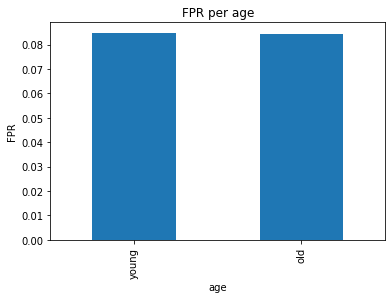

In [32]:
my_plot = dfprs.plot(kind='bar', legend=None, title="FPR per " + identifier)
my_plot.set_xlabel(identifier)
my_plot.set_ylabel("FPR")

In [33]:
dfnrs = pd.DataFrame(data={"identifier": identifiers, "FNR":fnrs})
dfnrs = dfnrs.groupby("identifier").sum().sort_values(by=["FNR"],ascending=False)

dfnrs.head()

,FNR
identifier,
old,0.07239
young,0.07123


Text(0, 0.5, 'FNR')

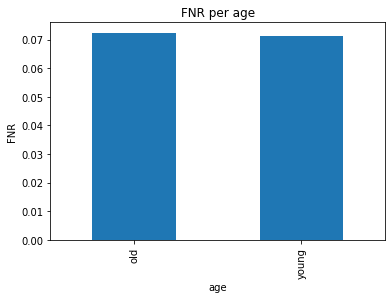

In [34]:
my_plot = dfnrs.plot(kind='bar', legend=None, title="FNR per " + identifier)
my_plot.set_xlabel(identifier)
my_plot.set_ylabel("FNR")

#### Calculate FNED and FPED

In [35]:
fped = 0
fned = 0

for _fpr, _fnr in zip(fprs, fnrs) :
    fped += abs(global_fpr - fpr)
    fned += abs(global_fnr - fnr)

print()
print("FPED: ", fped)
print("FNED: ", fned)


FPED:  0.00034690101757633984
FNED:  0.0011563367252544199
